# Assignment2

## Import Necessary Libraries

In [45]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Dataset Loading 

In [46]:
# Set device (use MPS for Apple Silicon, CUDA for other GPUs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Define the CIFAR-10 data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for compatibility with pre-trained models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


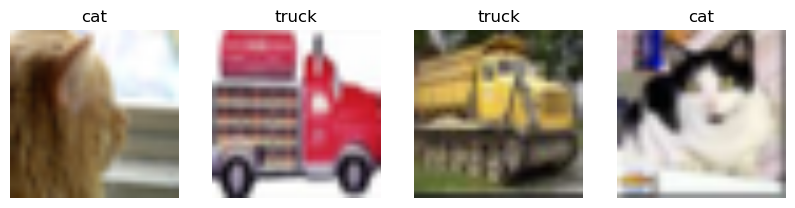

In [47]:
def show_cifar10_examples(dataset, classes, num_images=4):
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(data_loader))
    images = images / 2 + 0.5  # Unnormalize images
    np_images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show CIFAR-10 examples
show_cifar10_examples(train_dataset, classes)

In [39]:
# Helper function to get data loaders
def get_data_loaders(batch_size, subset_ratio=0.1):
    train_size = int(subset_ratio * len(train_dataset))
    val_size = int(train_size * 0.2)  # 20% of the training subset as validation set
    train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
    val_indices = np.random.choice(train_indices, val_size, replace=False)
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader

In [51]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to train and validate the model for one epoch
def train_validate_epoch(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    return train_loss / len(train_loader), train_accuracy, val_loss / len(val_loader), val_accuracy

# Function to plot learning curves
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Training and Validation Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Function to evaluate model on test data
def evaluate_test_data(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    return 100 * test_correct / test_total

def train_with_early_stopping(model_name, model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\n{model_name} - Epoch {epoch+1}/{num_epochs}")
        
        # Train and validate for one epoch
        train_loss, train_acc, val_loss, val_acc = train_validate_epoch(
            model, train_loader, val_loader, criterion, optimizer, device
        )
        
        # Append results to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print training and validation metrics for this epoch
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        
        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Plot learning curve
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name)
    return model

In [49]:
# Define models
def get_resnet18_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

def get_vgg16_model():
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    return model.to(device)

def get_mobilenet_v2_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    return model.to(device)

In [52]:
# Grid search for ResNet18
batch_sizes = [16, 32, 64]
learning_rates = [0.01, 0.001, 0.0001]
num_epochs = 10
best_resnet_test_acc = 0

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining ResNet18 with batch size {batch_size} and learning rate {lr}")
        train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size)
        resnet18_model = get_resnet18_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(resnet18_model.fc.parameters(), lr=lr)
        
        # Train with early stopping
        resnet18_model = train_with_early_stopping("ResNet18", resnet18_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
        
        # Evaluate on test data
        resnet_test_acc = evaluate_test_data(resnet18_model, test_loader)
        print(f"ResNet18 Test Accuracy: {resnet_test_acc:.2f}%")
        
        if resnet_test_acc > best_resnet_test_acc:
            best_resnet_test_acc = resnet_test_acc


Training ResNet18 with batch size 32 and learning rate 0.001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 32/32 [01:00<00:00,  1.89s/it]


Train Loss: 1.4191, Train Accuracy: 55.84%
Val Loss: 0.8953, Val Accuracy: 74.40%

ResNet18 - Epoch 2/10


Training:   0%|          | 0/157 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [54]:
# Train and evaluate VGG16
train_loader, val_loader, test_loader = get_data_loaders(batch_size=32)
vgg16_model = get_vgg16_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.classifier[-1].parameters(), lr=0.001)
vgg16_model = train_with_early_stopping("VGG16", vgg16_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
vgg16_test_acc = evaluate_test_data(vgg16_model, test_loader)
print(f"VGG16 Test Accuracy: {vgg16_test_acc:.2f}%")


VGG16 - Epoch 1/10


Validation: 100%|██████████| 32/32 [02:04<00:00,  3.89s/it]


Train Loss: 1.0361, Train Accuracy: 63.82%
Val Loss: 0.6885, Val Accuracy: 76.00%

VGG16 - Epoch 2/10


Training:   1%|          | 1/157 [00:25<1:07:16, 25.87s/it]


KeyboardInterrupt: 

In [42]:
# Train and evaluate MobileNetV2
mobilenet_v2_model = get_mobilenet_v2_model()
optimizer = optim.Adam(mobilenet_v2_model.classifier[-1].parameters(), lr=0.001)
mobilenet_v2_model = train_with_early_stopping("MobileNetV2", mobilenet_v2_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
mobilenet_v2_test_acc = evaluate_test_data(mobilenet_v2_model, test_loader)
print(f"MobileNetV2 Test Accuracy: {mobilenet_v2_test_acc:.2f}%")

NameError: name 'best_resnet_model' is not defined

In [43]:
# Display the final test accuracies in a heatmap
model_results = {
    "Model": ["ResNet18", "VGG16", "MobileNetV2"],
    "Test Accuracy (%)": [best_resnet_test_acc, vgg16_test_acc, mobilenet_v2_test_acc]
}

df_results = pd.DataFrame(model_results)
plt.figure(figsize=(6, 4))
sns.heatmap(df_results.pivot("Model", "Test Accuracy (%)", "Test Accuracy (%)"), annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
plt.title("Test Accuracy Comparison")
plt.show()